In [17]:
# Day 1: Data Acquisition & Preparation (using ccxt)


In [18]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

import time
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import math


In [19]:
# define symbol and date ranges
symbol      = 'BTC/USDT'
train_start = '2024-04-20'
train_end   = '2025-04-20'
test_start  = '2025-04-21'
test_end    = '2025-05-20'

In [20]:
# fetchs OHLCV from Binance via ccxt
# OHLCV: Open High Low Close Volume
# these are the standard data points for time series analysis in  market
exchange = ccxt.binance({'enableRateLimit': True})

def fetch_ohlcv(symbol, since, limit=500):
    data = exchange.fetch_ohlcv(
        symbol,
        timeframe='1d',
        since=exchange.parse8601(since + 'T00:00:00Z'),
        limit=limit
    )
    df = pd.DataFrame(data, columns=['timestamp','open','high','low','close','volume'])
    df['ds'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('ds', inplace=True)
    return df

# retrieves data covering train + test periods
full_df = fetch_ohlcv(symbol, since=train_start, limit=500)
# ensure daily frequency
full_df.index = pd.DatetimeIndex(full_df.index, freq='D')
# split into training & test sets
data      = full_df.loc[train_start:train_end]
actual_df = full_df.loc[test_start:test_end]

# time series for training
tseries = data['close']

In [21]:
# Day 2: Prophet and ARIMA(5,1,0) Forecasting

#prophet model: developed by meta, a piecewise linear model 
# that automatically multiples seasonalities

# arima model: assumes a stationary time series


In [22]:
prophet_df = tseries.reset_index().rename(columns={'ds':'ds','close':'y'})
m = Prophet(daily_seasonality=True)
m.fit(prophet_df)
horizon = (pd.to_datetime(test_end) - pd.to_datetime(train_end)).days
future  = m.make_future_dataframe(periods=horizon)
forecast = m.predict(future)

df_prophet = (
    forecast.set_index('ds')['yhat']
    .loc[test_start:test_end]
    .to_frame('Prophet')
)

arima_model = ARIMA(tseries, order=(5,1,0)).fit()
pred_arima = arima_model.get_forecast(steps=len(actual_df)).predicted_mean
pred_arima.index = actual_df.index
df_arima = pred_arima.to_frame('ARIMA')

22:23:52 - cmdstanpy - INFO - Chain [1] start processing
22:23:52 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Day 3: Holt winters Exponential Smoothing Forecasting 
# and Theta Model Forecasting

#Holt winters model: extends simple exponential smoothingby adding terms for 
# trend and seasonal cycles

# theta mode: computes two new series by adjusting curvature of the original

In [24]:
hw_model = ExponentialSmoothing(
    tseries,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
pred_hw = hw_model.forecast(len(actual_df))
pred_hw.index = actual_df.index
df_hw = pred_hw.to_frame('Holt_Winters')

theta_model = ThetaModel(tseries)
theta_fit   = theta_model.fit()
pred_theta  = theta_fit.forecast(len(actual_df))
pred_theta.index = actual_df.index
df_theta = pred_theta.to_frame('Theta')


In [25]:
# Day 4: Combining Actual & Predictions


In [26]:
actual = actual_df['close'].rename('Actual')
df_compare = pd.concat([actual, df_prophet, df_arima, df_hw, df_theta], axis=1).dropna()

evaluations = {
    'Prophet': math.sqrt(mean_squared_error(df_compare['Actual'], df_compare['Prophet'])),
    'ARIMA': math.sqrt(mean_squared_error(df_compare['Actual'], df_compare['ARIMA'])),
    'Holt-Winters': math.sqrt(mean_squared_error(df_compare['Actual'], df_compare['Holt_Winters'])),
    'Theta': math.sqrt(mean_squared_error(df_compare['Actual'], df_compare['Theta']))
}
for model, rmse in evaluations.items():
    print(f"RMSE {model:14}: {rmse:.2f}")

RMSE Prophet       : 23718.05
RMSE ARIMA         : 14502.60
RMSE Holt-Winters  : 14274.80
RMSE Theta         : 13486.67


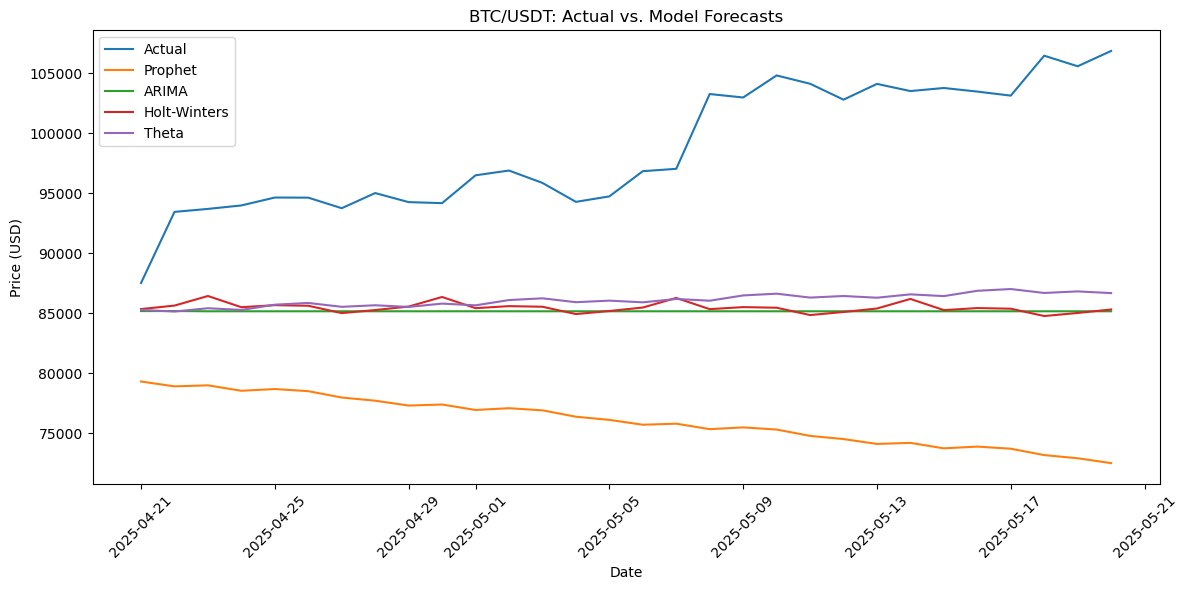

,Actual,Prophet,ARIMA,Holt_Winters,Theta
ds,,,,,
2025-04-21,87516.23,79313.024525,85180.455034,85347.357822,85279.560569
2025-04-22,93442.99,78908.357047,85183.859190,85637.508813,85140.484097
2025-04-23,93691.08,78994.899107,85162.821728,86436.008238,85417.547059
2025-04-24,93980.47,78540.663319,85162.488492,85503.298882,85274.311562
2025-04-25,94638.68,78687.247726,85162.145671,85673.759013,85711.729163
2025-04-26,94628.00,78508.941105,85162.594313,85621.936156,85856.752390
2025-04-27,93749.30,77979.062022,85163.181558,85011.546330,85534.908495
2025-04-28,95011.18,77714.682879,85163.129184,85266.145002,85664.663242
2025-04-29,94256.82,77310.015401,85163.143085,85556.295993,85524.710864


In [27]:
plt.figure(figsize=(12,6))
plt.plot(df_compare.index, df_compare['Actual'],       label='Actual')
plt.plot(df_compare.index, df_compare['Prophet'],      label='Prophet')
plt.plot(df_compare.index, df_compare['ARIMA'],        label='ARIMA')
plt.plot(df_compare.index, df_compare['Holt_Winters'], label='Holt-Winters')
plt.plot(df_compare.index, df_compare['Theta'],        label='Theta')
plt.title('BTC/USDT: Actual vs. Model Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# display first 10 rows of comparison table
df_compare.head(10)


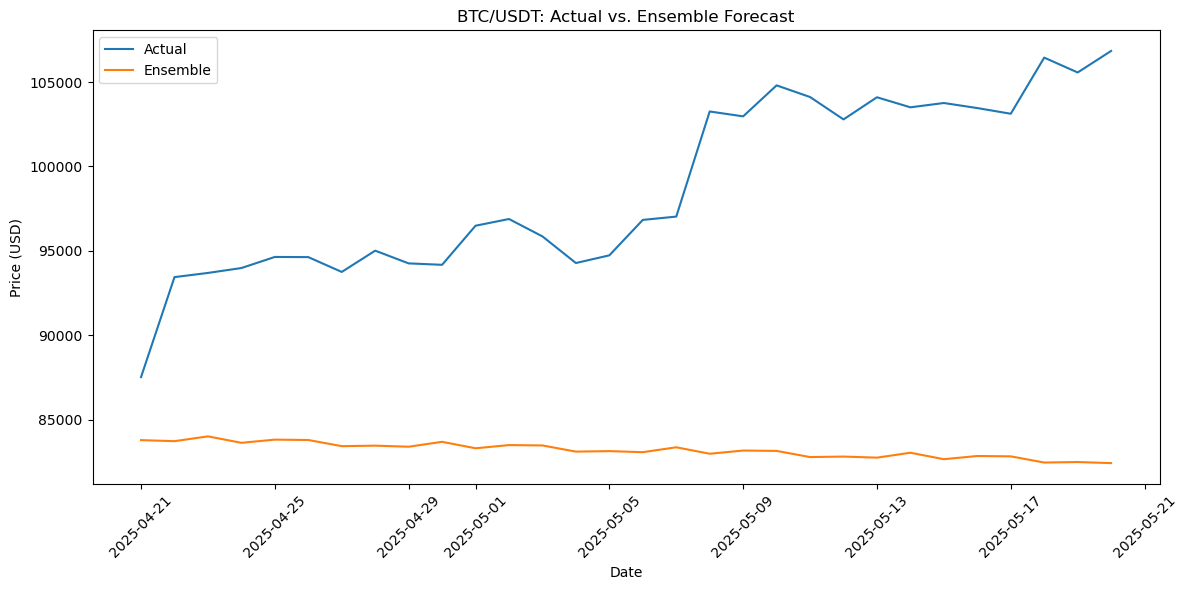

In [28]:
# Day 5: ensemble forecast (mean of all models)
df_compare['Ensemble'] = df_compare[['Prophet','ARIMA','Holt_Winters','Theta']].mean(axis=1)

# plot actual vs. ensemble
plt.figure(figsize=(12,6))
plt.plot(df_compare.index, df_compare['Actual'],    label='Actual')
plt.plot(df_compare.index, df_compare['Ensemble'], label='Ensemble')
plt.title('BTC/USDT: Actual vs. Ensemble Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Day 6: Percentage Error at 4-Day Intervals


Percentage Error at 4-Day Intervals (%) :
               Actual      Ensemble   ErrorPct
2025-04-21   87516.23  83780.099487   4.269072
2025-04-25   94638.68  83808.720393  11.443481
2025-04-29   94256.82  83388.541336  11.530496
2025-05-03   95856.42  83464.410057  12.927679
2025-05-07   97030.50  83355.726699  14.093273
2025-05-11  104118.00  82774.761154  20.499086
2025-05-15  103763.71  82648.929900  20.348906
2025-05-19  105573.74  82481.309879  21.873271


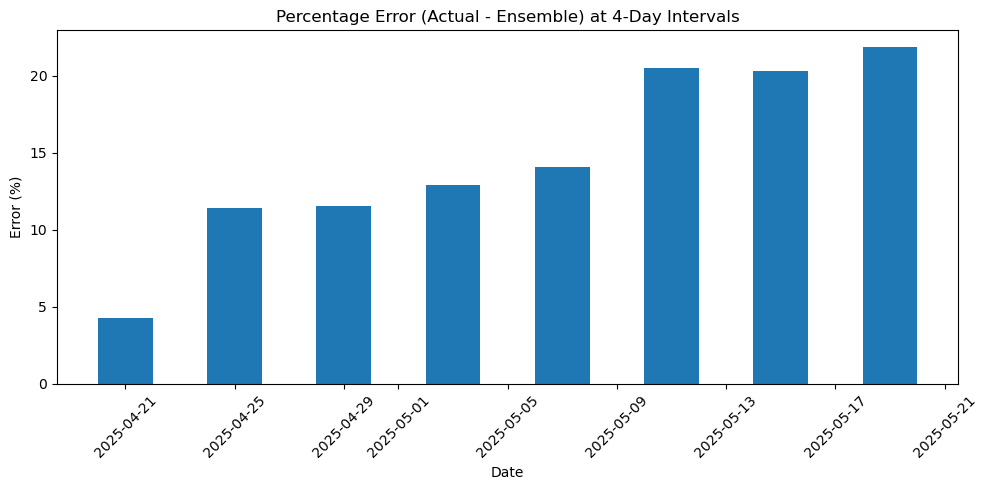

In [30]:
df_compare['ErrorPct'] = (df_compare['Actual'] - df_compare['Ensemble']) \
                          / df_compare['Actual'] * 100

# selects every 4-day tick as before
tick_dates = pd.date_range(start=test_start, end=test_end, freq='4D')
df_interval = df_compare.loc[tick_dates, ['Actual','Ensemble','ErrorPct']]

print("Percentage Error at 4-Day Intervals (%) :")
print(df_interval)

plt.figure(figsize=(10,5))
plt.bar(df_interval.index, df_interval['ErrorPct'], width=2)
plt.title('Percentage Error (Actual - Ensemble) at 4-Day Intervals')
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
plt.show()

# full comparison table with percentage errors
df_compare


,Actual,Prophet,ARIMA,Holt_Winters,Theta,Ensemble,ErrorPct
ds,,,,,,,
2025-04-21,87516.23,79313.024525,85180.455034,85347.357822,85279.560569,83780.099487,4.269072
2025-04-22,93442.99,78908.357047,85183.859190,85637.508813,85140.484097,83717.552287,10.407884
2025-04-23,93691.08,78994.899107,85162.821728,86436.008238,85417.547059,84002.819033,10.340644
2025-04-24,93980.47,78540.663319,85162.488492,85503.298882,85274.311562,83620.190564,11.023864
2025-04-25,94638.68,78687.247726,85162.145671,85673.759013,85711.729163,83808.720393,11.443481
2025-04-26,94628.00,78508.941105,85162.594313,85621.936156,85856.752390,83787.555991,11.455852
2025-04-27,93749.30,77979.062022,85163.181558,85011.546330,85534.908495,83422.174601,11.015683
2025-04-28,95011.18,77714.682879,85163.129184,85266.145002,85664.663242,83452.155077,12.165963
2025-04-29,94256.82,77310.015401,85163.143085,85556.295993,85524.710864,83388.541336,11.530496


In [32]:

# computeng the average percentage error over the entire test month
avg_error_pct = df_compare['ErrorPct'].mean()
print(f"Average Percentage Error for the Month: {avg_error_pct:.2f}%")

Average Percentage Error for the Month: 15.49%
